# DS Project 2: Kickstarter data set  
by Sandra Schwegmann & Marvin Lorenzen

## Project Goal

Business Case:

We are a non-profit organization that helps people to find out which probability they have to get funded by kickstarters with their projects and what they can do to improve their chances
- So we want to find out which features have an impact wheather a Kickstarter project is succesfull or not.
- Form a good model which predicts wether a project will be successful. 

## Data Describtion

        backers_count:              number of supporters for a project
        blurb                       teaser sentence
        category                    dictonary with entries to te topic "category"
        converted_pledged_amount:   collected money from backers in US-Dollar
        country                     initials from the country in which the project was started 
        created_at                  Time at which the project was created 
        creator                     dictonary with informations about the creator
        currency                    currency in which the project is specified 
        currency_symbol             Symbol of the currency 
        currency_trailing_code      ?
        current_currency            currency in which the money is transferred
        deadline                    Time at which the project ends 
        disable_communication       Is there a way to communicate with the creator
        friends                     Column with no entries
        fx_rate                     Cenversion rate 
        goal                        target sum
        id                          ID for the project
        is_backing                  ?
        is_starrable                ?
        is_starred                  ?
        launched_at                 Time at which the project was started 
        location                    dictonary with entries to te topic "location"
        name                        name of the project 
        permissions                 300 non-null object
        photo                       dictonary with entries to te topic "photo"
        pledged                     collected money from backers
        profile                     dictonary with entries to te topic "profile"
        slug                        ?
        source_url                  URL from the Kickstarter project 
        spotlight                   the spotlight-function is an integrated homepage
        staff_pick                  tool to connect creators and backers
        state                       status of the project
        state_changed_at            Time at which the status of project changed
        static_usd_rate             factor for conversion in USD
        urls                        dictonary with entries to te topic "URl"
        usd_pledged                 promised money in usd
        usd_type                    Where does the money come from 

# Data Mining

In [312]:
# import the required libaries 
import pandas as pd
import glob
import numpy as np
import operator
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import median
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.patches as mpatches

%matplotlib inline 
sns.set(style="darkgrid")
sns.set_palette=("pastel")

Rseed = 42

In [313]:
# Read in data: loop over all files
path = '/Users/ahoi/nf-may2020/hh-2020-ds1-Project2-Kickstarter/data'
filenames = glob.glob(path + "/*.csv")
comlete_csv =[]

for i in filenames:
    comlete_csv.append(pd.read_csv(i))
    
df = pd.concat(comlete_csv, ignore_index = True)


In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
backers_count               209222 non-null int64
blurb                       209214 non-null object
category                    209222 non-null object
converted_pledged_amount    209222 non-null int64
country                     209222 non-null object
created_at                  209222 non-null int64
creator                     209222 non-null object
currency                    209222 non-null object
currency_symbol             209222 non-null object
currency_trailing_code      209222 non-null bool
current_currency            209222 non-null object
deadline                    209222 non-null int64
disable_communication       209222 non-null bool
friends                     300 non-null object
fx_rate                     209222 non-null float64
goal                        209222 non-null float64
id                          209222 non-null int64
is_backing                  300 

In [315]:
df.head(2)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,...,babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",28645.0,international
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,...,the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1950.0,domestic


In [316]:
# clean data from empty spaces, line breaks, etc.
dict_list1 = ['location','profile','creator']
for names in dict_list1:
    df[names] = df[names].str.replace(':null,',':None,')
    df[names] = df[names].str.replace(':false,',':False,')
    df[names] = df[names].str.replace(':true',':True')
    df[names] = df[names].str.replace('\n', '')
    df[names] = df[names].str.replace('\t', '')

In [317]:
# get fom creator ids -> remaining parts are ignored
# First separate creator elements
new2 = df["creator"].str.replace(", ", "_").str.split(",", n = 8, expand = True)
# now pick first column in new2 and split at :
test = new2[0].str.split(":")
# pick 2. column in test (where ids are written in)
test2 = list(map(operator.itemgetter(1), test))
# and make a new column in df with ids
df["creator_id"]=pd.Series(test2)
# convert ids to numeric values
df["creator_id"] = pd.to_numeric(df["creator_id"])

In [318]:
# prepare profile data
# First separate creator elements
new  = df["profile"].str.replace('," ', '_" ')
new  = df["profile"].str.replace(',"', ';;"')
new2 = new.str.split(";;", n = 16, expand = True)
# now drop column 4:
#new3 = new2.drop(4, axis =1)
# change blurb to has or has no blurb
new2[5][new2[5]!='"blurb":"none"'] = '"blurb":"1"' #0 if new3[5]== "none" else 1
new2[5][new2[5]=='"blurb":"none"'] = '"blurb":"0"' #0 if new3[5]== "none" else 1
# change link_text to has or has not
#new3[10][new3[10]!='"link_text":"none"'] = '"link_text":"1"' #0 if new3[5]== "none" else 1
#new3[10][new3[10]=='"link_text":"none"'] = '"link_text":"0"' #0 if new3[5]== "none" else 1

new2[17]='"dummy":"dummy"}'
# pick columns of interest: 
new2["profile"]= new2[[0,1,2,3,5,17]].apply(lambda x: ','.join(x), axis=1)
# write data in df
df["profile_test"] =new2["profile"]

In [319]:
df["profile_test"][0]

'{"id":3508024,"project_id":3508024,"state":"inactive","state_changed_at":1541459205,"blurb":"1","dummy":"dummy"}'

In [320]:
#new3[new3[6].str.contains("Kickstarter & Indiegogo_the SoleHugger Secret 2.0")]
df.profile[119063]

'{"id":3281282,"project_id":3281282,"state":"active","state_changed_at":1523592275,"name":"Secret 2.0: The World\'s FIRST, REAL NO-SHOW SOCK by Sheec.","blurb":"With over 1,000 backers on Kickstarter & Indiegogo, the SoleHugger Secret 2.0 is now fully available on Sheecs.com!","background_color":"","text_color":"","link_background_color":"","link_text_color":"","link_text":"BUY NOW !","link_url":"http://bit.ly/2y73R8J","show_feature_image":True,"background_image_opacity":0.8,"feature_image_attributes":{"id":21593580,"image_urls":{"default":"https://ksr-ugc.imgix.net/assets/021/593/580/3794f72b493f964edfde4b8620011789_original.jpg?ixlib=rb-1.1.0&w=700&fit=max&v=1529077865&auto=format&frame=1&q=92&s=bb3a91cf05e42ff63f7c72ee59731821","baseball_card":"https://ksr-ugc.imgix.net/assets/021/593/580/3794f72b493f964edfde4b8620011789_original.jpg?ixlib=rb-1.1.0&crop=faces%2Cedges&w=560&h=315&fit=crop&v=1529077865&auto=format&frame=1&q=92&s=a0e8b1ef7ab78689a909cc6eac86cb50"}},"should_show_feature

In [321]:
df.profile.head()

0    {"id":3508024,"project_id":3508024,"state":"in...
1    {"id":3094785,"project_id":3094785,"state":"ac...
2    {"id":359847,"project_id":359847,"state":"inac...
3    {"id":2825329,"project_id":2825329,"state":"in...
4    {"id":417385,"project_id":417385,"state":"inac...
Name: profile, dtype: object

In [322]:
# prepare location data
# dummy for NaN entries
location_dummy= '{"id":"","name":"","slug":"","short_name":"","displayable_name":"","localized_name":"",\
                "country":"","state":"","type":"","is_root":None,"urls":{}}'
#replace NaNs with dummy
df.location[df.location.isnull()] = location_dummy

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [323]:
# extraction of data dictonaries in 'category','location'
dict_list = ['profile_test', 'category','location'] #, null false true

for names in dict_list:
    print(names)
    new_name     = names+'new'
    suffix       = names+'_'
    df[new_name] = df[names].apply(eval)
    test         = df[new_name].apply(pd.Series)
    test         = test.add_prefix(suffix)
    df           = pd.concat([df,test],axis=1)  
    
#df['categoryNew']= df.category.apply(eval)
#test = df["categoryNew"].apply(pd.Series)
#test = test.add_prefix('category_')
#df = pd.concat([df,test],axis=1)   

profile_test
category
location


In [324]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,location_name,location_slug,location_short_name,location_displayable_name,location_localized_name,location_country,location_state,location_type,location_is_root,location_urls
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,...,Novato,novato-ca,"Novato, CA","Novato, CA",Novato,US,CA,Town,False,{'web': {'discover': 'https://www.kickstarter....
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,...,Euless,euless-tx,"Euless, TX","Euless, TX",Euless,US,TX,Town,False,{'web': {'discover': 'https://www.kickstarter....
2,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,True,...,Hollywood,hollywood-los-angeles-ca,"Hollywood, CA","Hollywood, Los Angeles, CA",Hollywood,US,CA,Suburb,False,{'web': {'discover': 'https://www.kickstarter....
3,3,The Mist of Tribunal is a turn-based card game...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,False,...,Kaunas,kaunas-kaunas-lt,"Kaunas, Lithuania","Kaunas, Lithuania",Kaunas,LT,Kaunas County,Town,False,{'web': {'discover': 'https://www.kickstarter....
4,3,"Livng with a brain impairment, what its like t...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,True,...,Traverse City,traverse-city-mi,"Traverse City, MI","Traverse City, MI",Traverse City,US,MI,Town,False,{'web': {'discover': 'https://www.kickstarter....


## General Overview

In [325]:
# Copy the DataFrame to keep the original data 
df2 = pd.DataFrame.copy(df)

In [326]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 66 columns):
backers_count                    209222 non-null int64
blurb                            209214 non-null object
category                         209222 non-null object
converted_pledged_amount         209222 non-null int64
country                          209222 non-null object
created_at                       209222 non-null int64
creator                          209222 non-null object
currency                         209222 non-null object
currency_symbol                  209222 non-null object
currency_trailing_code           209222 non-null bool
current_currency                 209222 non-null object
deadline                         209222 non-null int64
disable_communication            209222 non-null bool
friends                          300 non-null object
fx_rate                          209222 non-null float64
goal                             209222 non-null float64
id

### drop unimportant columns

In [327]:
#drop first columns, which have no explanatory content at the first view
df2.drop(["category", "creator", "location", "profile", "slug", "profile_test",
         "profile_testnew", "profile_test_state_changed_at", "profile_test_blurb", 
         "profile_test_dummy", "categorynew", "category_id", "category_urls", 
         "locationnew", "location_id", "location_slug", "location_short_name", "location_displayable_name",
         "location_state", "location_is_root", "location_urls", 'photo','friends',
         'permissions','currency_symbol', 'source_url', "urls"
         ],axis=1, inplace=True)

In [328]:
df2.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'country',
       'created_at', 'currency', 'currency_trailing_code', 'current_currency',
       'deadline', 'disable_communication', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'name',
       'pledged', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'usd_pledged', 'usd_type', 'creator_id',
       'profile_test_id', 'profile_test_project_id', 'profile_test_state',
       'category_name', 'category_slug', 'category_position',
       'category_parent_id', 'category_color', 'location_name',
       'location_localized_name', 'location_country', 'location_type'],
      dtype='object')

# Data Cleaning

## Missing data

In [329]:
missing = pd.DataFrame(df2.isnull().sum(),columns=['Number'])
missing[missing.Number!=0]

,Number
blurb,8
is_backing,208922
is_starred,208922
usd_type,480
category_parent_id,9041


In [330]:
df2["is_starred"].value_counts()

False    298
True       2
Name: is_starred, dtype: int64

In [331]:
df2["usd_type"].value_counts()

international    104508
domestic         104234
Name: usd_type, dtype: int64

In [332]:
df2["category_parent_id"].value_counts()

11.0    27402
14.0    26529
16.0    20772
18.0    19899
1.0     19628
10.0    15676
12.0    13940
9.0     11870
7.0      8636
3.0      8430
15.0     7475
17.0     6299
26.0     5962
13.0     5098
6.0      2565
Name: category_parent_id, dtype: int64

In [333]:
df2.drop(["is_starred", "is_backing"], axis= 1, inplace=True)

- what are wo doing with "blurb"? There are only 8 NaN but we can not make a average since "blurb" is an object
- drop "is_backing" and "is_starred" because there to much missing values
    - in "is_backing" there are 300 False entries 
    - in "is_starred" there are 298 False entries and 2 True entries 
- don´t drop usd_type maybe we finde an indicator wether the project is international or domestic
- bevore we drop category_parent_id we take a deeper loock on this feature 

## prepare data

### "state" our variabel we want to predict

In [334]:
# delete all projects that don't have the status "failed" or "successful"

df2 = df2[df2.state!='canceled']
df2 = df2[df2.state!='live']
df2 = df2[df2.state!='suspended']
df2.shape

(192664, 37)

In [335]:
df2["state"].value_counts()

successful    117465
failed         75199
Name: state, dtype: int64

We have 192664 data points left with 37 features. 

117465 of them are successful and 75199 are failed.

### "blurb" count lenght of the string?

In [336]:
# What we are doing with "blurb"? There are 2 entries of missing data 
df2[df["blurb"].isnull()]

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,backers_count,blurb,converted_pledged_amount,country,created_at,currency,currency_trailing_code,current_currency,deadline,disable_communication,...,profile_test_state,category_name,category_slug,category_position,category_parent_id,category_color,location_name,location_localized_name,location_country,location_type
65168,39,NaN,8675,DE,1504364375,EUR,False,USD,1507625188,False,...,inactive,Ready-to-wear,fashion/ready-to-wear,8,9.0,16752598,Munich,Munich,DE,Town
108662,0,NaN,0,US,1509679461,USD,True,USD,1515800048,False,...,inactive,Digital Art,art/digital art,3,1.0,16760235,Los Angeles,Los Angeles,US,Town


-> create a new feature that specifies the length of the name. 

In [337]:
# check the dircribtion of this new feature 
df2["blurb_length"] = df2.blurb.str.len()
df2["blurb_length"].describe()

count    192662.000000
mean        112.431767
std          26.573717
min           1.000000
25%         101.000000
50%         124.000000
75%         132.000000
max         196.000000
Name: blurb_length, dtype: float64

In [338]:
df2["blurb_length"].head(5)

1    125.0
2    108.0
3    133.0
4    121.0
5    134.0
Name: blurb_length, dtype: float64

In [339]:
#The two entries that are missing are set to a lenght of zero
df2["blurb_length"][df2["blurb_length"].isnull()] = 0

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [340]:
# drop the column "blurb", because it's not longer necessary
df2.drop(["blurb"], inplace= True, axis=1)

### "name"

In [341]:
df2["name"].head()

1                              The Ofrenda Oracle Deck
2    Record Electra's Debut Album (Pop, Rock, Class...
3                   The Mist of Tribunal - A Card Game
4             Help change the face of Brain Impairment
5                      Annapolis Chamber Music Project
Name: name, dtype: object

In [342]:
# like "blurb" create a new feature with the length of the name 
df2["name_length"] = df2["name"].str.len()
df2["name_length"].describe()

count    192664.000000
mean         35.148377
std          15.695316
min           1.000000
25%          22.000000
50%          35.000000
75%          49.000000
max          85.000000
Name: name_length, dtype: float64

In [343]:
#drop the column "name"
df2.drop(["name"], inplace= True, axis=1)

### "country"

In [344]:
df2["country"].value_counts()

US    137788
GB     21235
CA      8896
AU      4383
DE      3048
FR      2377
IT      2063
MX      2038
ES      1697
NL      1649
SE      1281
HK       953
NZ       848
DK       839
SG       624
CH       597
IE       575
BE       496
NO       453
AT       439
JP       330
LU        55
Name: country, dtype: int64

there are 22 countries in which the projects are started. The most of them in the United States. Create a new Column with a dummy Variable, if the project has started in the US 1 = yes or 0=no 

In [345]:
# create dummie variables from column "country"
dummies_country = pd.get_dummies(df2["country"])
dummies_country.head()

,AT,AU,BE,CA,CH,DE,DK,ES,FR,GB,...,IT,JP,LU,MX,NL,NO,NZ,SE,SG,US
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [346]:
# put dummie variable "US" (if the Country USA? yes=1, no=0)in our dataframe
df2["country_US"] = dummies_country["US"]
df2.head(1)

,backers_count,converted_pledged_amount,country,created_at,currency,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,...,category_position,category_parent_id,category_color,location_name,location_localized_name,location_country,location_type,blurb_length,name_length,country_US
1,47,1950,US,1501684093,USD,True,USD,1504976459,False,1.0,...,4,12.0,51627,Euless,Euless,US,Town,125.0,23,1


### "created_at"/ "deadline"/ "launched_at"

In [347]:
# all feature that have a time specification
df2["created_at"].head(1)
df2["deadline"].head()
df2["launched_at"].head(1)
df2["state_changed_at"].head(1)

1    1504976459
Name: state_changed_at, dtype: int64

In [348]:
# create a new feature that shows the time between the start and the end of the project
df2["duration"] = df2["deadline"] -df2["launched_at"]
df2["duration"] =df2["duration"] / (60*60*24)
df2["duration"].head()

1    30.000000
2    30.000000
3    59.958333
4    30.000000
5    30.000000
Name: duration, dtype: float64

In [349]:
# create a new feature that shows the time between the creating and the starting of the project
df2["preparation"] = df2["launched_at"] - df2["created_at"]
df2["preparation"] = df2["preparation"] / (60*60*24)
df2["preparation"].head()

1      8.106088
2    224.928958
3      5.383160
4      4.102500
5    159.368009
Name: preparation, dtype: float64

In [350]:
# create a new feature that shows the time between the start and the real end of the project
df2["act_duration"] =df2["state_changed_at"] - df2["launched_at"]
df2["act_duration"] = df2["act_duration"] / (60*60*24)
df2["act_duration"].head()

1    30.000000
2    30.000000
3    59.958333
4    30.000000
5    30.000000
Name: act_duration, dtype: float64

In [351]:
# drop all features that ar not longer necessary as the new features have been created
df2.drop(["created_at", "deadline", "launched_at", "state_changed_at"], inplace= True, axis=1)

### what is fx_rate ?

In [352]:
# what is fx_rate ?
df2["fx_rate"].head()

1    1.000000
2    1.000000
3    1.308394
4    1.000000
5    1.000000
Name: fx_rate, dtype: float64

In [353]:
# we have found no connection an no explonation for the variable fx_rate, that's why we drop this column
df2.drop(["fx_rate"], inplace= True, axis=1)

### goal

In [354]:
# convert "goal" in USD 
df2['USD_goal'] = df2["goal"]*df2["static_usd_rate"]

In [355]:
# drop goal 
df2.drop(["goal"], inplace= True, axis=1)

### "id"

In [356]:
df2["id"].head(1)

1    928751314
Name: id, dtype: int64

In [357]:
# count double entires in the column "id" and save the results in a new column
df2["count_id"] = df2.groupby("id")["id"].transform('count')

In [358]:
df2["count_id"].value_counts()

1    145294
2     47370
Name: count_id, dtype: int64

In [359]:
# now drop the column "id"
df2.drop(["id"], inplace= True, axis=1)

### "is_starrable"

In [360]:
df2["is_starrable"].value_counts()

False    192664
Name: is_starrable, dtype: int64

In [361]:
# drop this variable, because all entries are "False" the column "is_starrable" has no content for our model
df2.drop(["is_starrable"], inplace= True, axis=1)

### "pledged" and "usd_pledged"

In [362]:
# take a look on the the difference between the varaibles "pledged" and "usd_pledged"
df2["pledged"].head(10)

1      1950.0
2     22404.0
3       136.0
4      2820.0
5      3725.0
6      3890.0
7       660.0
8       375.0
9      1954.0
10        0.0
Name: pledged, dtype: float64

In [363]:
df2["usd_pledged"].head(10)

1      1950.000000
2     22404.000000
3       165.384934
4      2820.000000
5      3725.000000
6      3890.000000
7       660.000000
8       529.786729
9      2516.160602
10        0.000000
Name: usd_pledged, dtype: float64

In [364]:
# pledged * static_usd_rate = usd_pledged
df2["static_usd_rate"].head(10)

1     1.000000
2     1.000000
3     1.216066
4     1.000000
5     1.000000
6     1.000000
7     1.000000
8     1.412765
9     1.287697
10    1.000000
Name: static_usd_rate, dtype: float64

In [365]:
# drop "pledged" because we have "usd_pledged" which is "pledged" convert in USD 
df2.drop(["pledged"], inplace= True, axis=1)

### "spotlight"

In [366]:
df2["spotlight"].value_counts()

True     117465
False     75199
Name: spotlight, dtype: int64

In [367]:
# drop because only the successful projects can use the spotlight function 
df2.drop(["spotlight"], inplace= True, axis=1)

### "staff_pick"

In [368]:
df2["staff_pick"].value_counts()

False    166671
True      25993
Name: staff_pick, dtype: int64

### "creator_id"

In [369]:
# count double entires in the column "creator_id" and save the reults in a new column
df2["count_creator_id"] = df2.groupby("creator_id")["creator_id"].transform('count')

In [370]:
df2["count_creator_id"].value_counts()

1     117387
2      46008
3       9723
4       5868
5       2975
6       2256
7       1372
8       1192
9        909
10       570
11       473
13       364
14       322
12       288
15       285
16       272
19       247
18       234
25       175
20       160
22       132
17       119
28       112
27       108
23        92
21        84
39        78
75        75
34        68
32        64
30        60
60        60
59        59
55        55
53        53
26        52
52        52
51        51
45        45
40        40
37        37
33        33
31        31
24        24
Name: count_creator_id, dtype: int64

### "profile_test_project_id"

In [371]:
# count double entires in the column "count_profile_id" and save the reults in a new column
df2["count_profile_id"] = df2.groupby("profile_test_project_id")["profile_test_project_id"].transform('count')

In [372]:
df2["count_profile_id"].value_counts()

1    145294
2     47370
Name: count_profile_id, dtype: int64

In [373]:
# same results like the column id, that's why drop the column 
df2.drop(["profile_test_project_id", "count_profile_id"], inplace= True, axis=1)

### profile_test_state

In [374]:
df2["profile_test_state"].value_counts()

inactive    155264
active       37400
Name: profile_test_state, dtype: int64

### "category_name"

In [375]:
df2["category_name"].head()

1      Playing Cards
2               Rock
3      Playing Cards
4         Nonfiction
5    Classical Music
Name: category_name, dtype: object

In [376]:
len(df2["category_name"].value_counts())

159

### "category_slug"

In [377]:
len(df2["category_slug"].value_counts())

169

In [378]:
df2["category_slug"].head(1)

1    games/playing cards
Name: category_slug, dtype: object

In [379]:
# create a new feature with the parent category
df2["parent_category"], df2["category"] = df2["category_slug"].str.split('/', 1).str

In [380]:
df2["parent_category"].value_counts()

music           25920
film & video    25653
technology      19476
art             19217
publishing      18690
food            14948
games           12452
fashion         10764
comics           8190
design           7680
photography      7390
crafts           6549
theater          6478
journalism       5338
dance            3919
Name: parent_category, dtype: int64

In [381]:
len(df2["category"].value_counts())

144

In [382]:
# drop "category" because category_name have more contant
df2.drop(["category_slug", "category"], inplace = True, axis=1 )

### "Category_position" and "category_parent_id"

In [383]:
df2["category_position"].value_counts()

5     21489
3     20897
4     20145
2     16881
6     14675
7     13845
1     12937
8     11412
9     11177
10    10225
14     6753
11     6515
15     4677
12     4455
13     4247
17     3567
16     3303
18     2997
19     2467
Name: category_position, dtype: int64

In [384]:
df2["category_parent_id"].value_counts()

11.0    25411
14.0    25199
16.0    19147
18.0    18397
1.0     18381
10.0    14437
12.0    12398
9.0     10591
3.0      7837
7.0      7489
15.0     6759
17.0     5920
26.0     5353
13.0     4624
6.0      2445
Name: category_parent_id, dtype: int64

### "location name", "location_country" and "location_localized_name"

In [385]:
len(df2["location_name"].value_counts())

12343

In [386]:
df2["location_name"].head()

1           Euless
2        Hollywood
3           Kaunas
4    Traverse City
5        Annapolis
Name: location_name, dtype: object

In [387]:
df2["location_localized_name"].head()

1           Euless
2        Hollywood
3           Kaunas
4    Traverse City
5        Annapolis
Name: location_localized_name, dtype: object

In [388]:
len(df2[df2["location_name"] != df2["location_localized_name"]])

0

In [389]:
# there are no difference betweeen "location_name" and "location_localized_name", that´s why we drop one of them
df2.drop(["location_localized_name"], inplace= True, axis = 1)

In [390]:
df2["location_country"].value_counts()

US    133194
GB     20553
CA      8659
AU      4186
DE      2974
FR      2450
MX      2219
IT      2172
ES      1771
NL      1534
SE      1273
HK       946
NZ       871
DK       825
JP       692
SG       608
CH       601
IE       580
NO       455
BE       451
AT       440
CN       342
         215
IN       193
PL       158
UA       152
KR       150
PR       138
TH       135
IL       125
       ...  
NC         2
SS         2
AX         2
DJ         2
SX         2
FM         2
KW         2
SO         2
AL         2
TC         2
AZ         1
GQ         1
VA         1
MR         1
LC         1
KN         1
GI         1
KI         1
TL         1
GA         1
LS         1
BJ         1
SC         1
SZ         1
SD         1
TJ         1
QA         1
CV         1
MQ         1
SA         1
Name: location_country, Length: 196, dtype: int64

In [391]:
# After deleting so many rows and columns, let's take another look at the missing data
missing = pd.DataFrame(df2.isnull().sum(),columns=['Number'])
missing[missing.Number!=0]

,Number
usd_type,38
category_parent_id,8276


In [392]:

df2.drop(["category_parent_id"], axis=1, inplace = True)

In [393]:
df2.drop([
    "converted_pledged_amount", "current_currency",
    "disable_communication","static_usd_rate", 
    "creator_id",
    "profile_test_id",
    "profile_test_state", "category_color", "location_name"],
    axis=1, inplace=True)

In [394]:
df2.nunique()

backers_count               3206
country                       22
currency                      14
currency_trailing_code         2
staff_pick                     2
state                          2
usd_pledged                75218
usd_type                       2
category_name                159
category_position             19
location_country             196
location_type                 10
blurb_length                 153
name_length                   85
country_US                     2
duration                   47963
preparation               160540
act_duration               50102
USD_goal                   46164
count_id                       2
count_creator_id              44
parent_category               15
dtype: int64

# Data Exploration

## Train- Test Split

In [395]:
X = df2.drop("state", axis=1)
y = df2["state"]
print(X.shape)
print(y.shape)

(192664, 21)
(192664,)


In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [397]:
train_data = X_train.join(y_train)

## successful

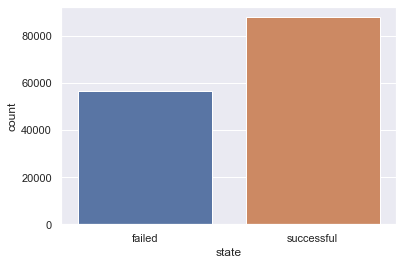

In [398]:
ax = sns.countplot(x="state", data=train_data)
plt.savefig('figures/bar_successful.png')

## USD-Goal

In [399]:
df2["USD_goal"].describe()

count    1.926640e+05
mean     3.778767e+04
std      1.065709e+06
min      1.000000e-02
25%      1.500000e+03
50%      5.000000e+03
75%      1.244704e+04
max      1.523501e+08
Name: USD_goal, dtype: float64

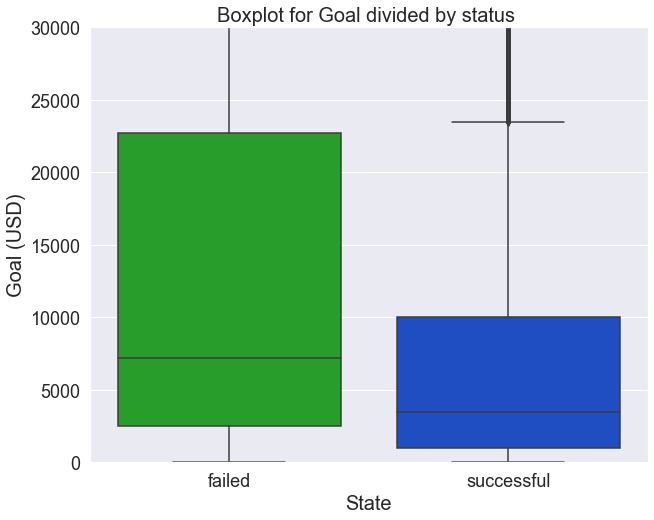

In [400]:
plt.figure(figsize=(10,8))
ax= sns.boxplot(x="state", y= "USD_goal", data= train_data, palette=sns.xkcd_palette(['green','blue']))
ax.set(ylim=(0, 30000));

ax.set_xlabel("State",fontsize=20);
ax.set_ylabel("Goal (USD)",fontsize=20);
ax.set_title("Boxplot for Goal divided by status ",fontsize=20);
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
plt.savefig('figures/boxplot_USD_goal(median)_state1.png')

In [401]:
train_data.groupby("state")["USD_goal"].median()

state
failed        7213.27935
successful    3500.00000
Name: USD_goal, dtype: float64

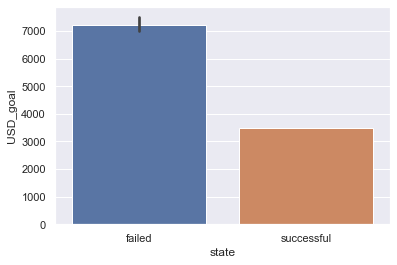

In [402]:
sns.barplot(x="state", y="USD_goal", data=train_data, estimator=median)
plt.savefig('figures/bar_USD_goal(median)_state.png')

In [403]:
#plt.figure(figsize=(12,5))
#ax= sns.barplot(x=SucCountry.index, y= SucCountry, palette='pastel')
#ax.ylabel("Goal (in USD)", fontsize = 12)
#ax.xlabel("Category", fontsize = 12)
#ax.set_xlabel("Country",fontsize=14);
#ax.set_ylabel("Percent successful",fontsize=14);
#ax.set_title("Percent of successful projects per country",fontsize=14);
#plt.yticks(fontsize= 19)
#plt.yticks(fontsize= 19)
#plt.savefig('figures/Country_succes_inPercent.png')

## country

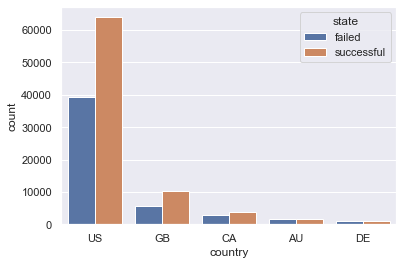

In [404]:
sns.countplot(x="country", data=train_data, hue="state", order=train_data["country"].value_counts().iloc[:5].index)
plt.savefig('figures/countplot_top_five_countrys.png')

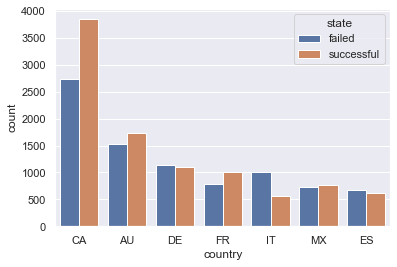

In [405]:
sns.countplot(x="country", data=train_data, hue="state", order=train_data["country"].value_counts().iloc[2:9].index)
plt.savefig('figures/countplot_top_countrys_without_USandGB.png')

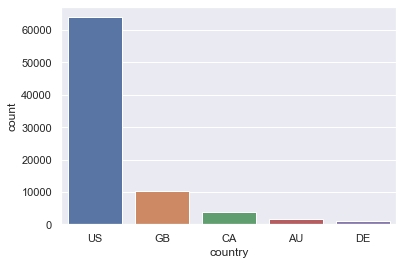

In [406]:
sns.countplot(x="country", data=train_data[train_data["state"]=="successful"], order=train_data["country"].value_counts().iloc[:5].index)

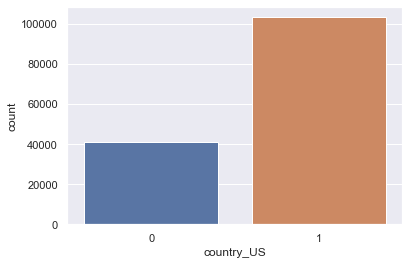

In [407]:
sns.countplot(x="country_US", data=train_data)
plt.savefig('figures/barplot_country_US.png')

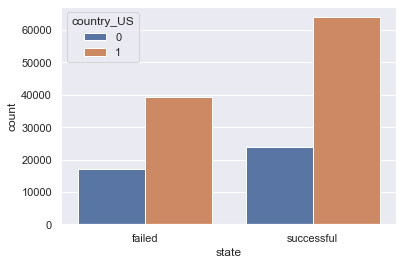

In [408]:
sns.countplot(x="state", data=train_data, hue="country_US")
plt.savefig('figures/barplot_country_US_state.png')

## "creator ID"

In [409]:
train_data["count_creator_id"].value_counts()


1     88051
2     34494
3      7264
4      4384
5      2241
6      1700
7      1027
8       908
9       675
10      442
11      351
13      279
14      249
12      216
15      209
16      207
18      174
19      171
25      129
20      128
17       97
22       96
28       86
27       82
21       65
23       61
39       58
75       54
30       54
32       50
34       48
26       47
51       42
52       42
59       42
55       41
60       41
53       38
45       30
37       29
31       28
33       28
40       27
24       13
Name: count_creator_id, dtype: int64

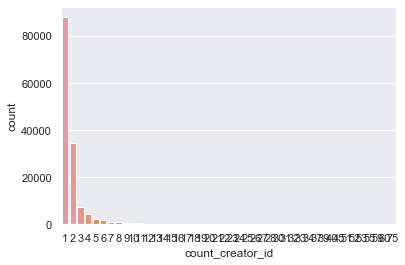

In [410]:
sns.countplot(x="count_creator_id", data=train_data)


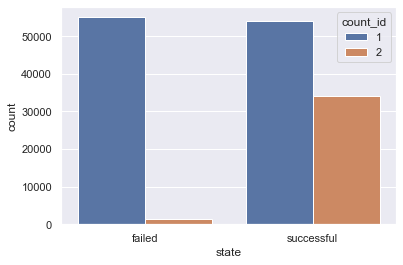

In [411]:
sns.countplot(x="state", data=train_data, hue="count_id")

## "category"

In [412]:
train_data["help_count"]=1

In [413]:
category_successfull = train_data[train_data["state"]== "successful"].groupby("parent_category")["help_count"].sum()
#category_successfull

In [414]:
category_count = train_data.groupby("parent_category")["help_count"].sum()
#category_count

In [415]:
relationship = (category_successfull/category_count)*100
relationship.sort_values(ascending=False, inplace=True)
# relationship

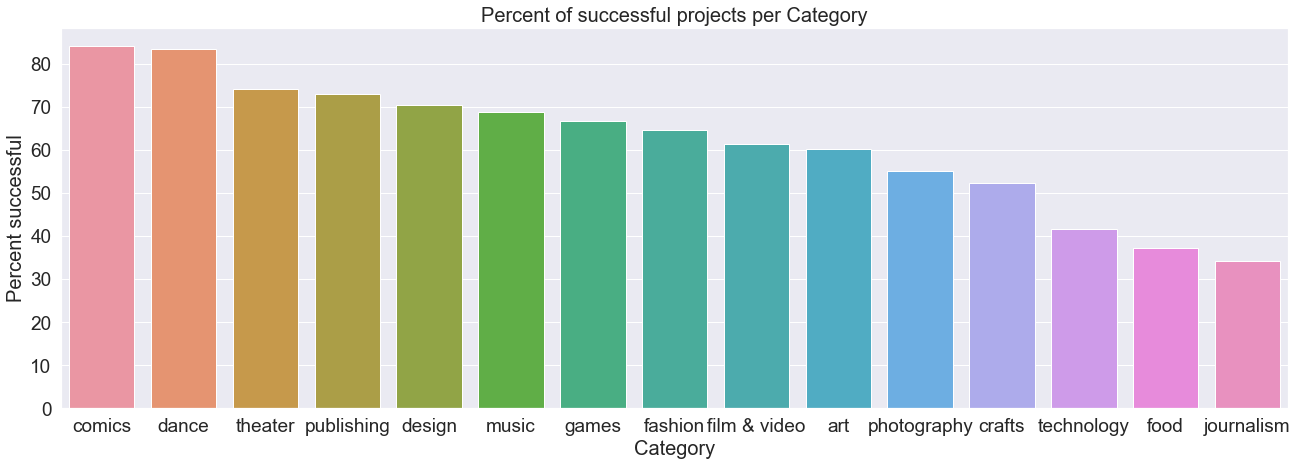

In [416]:
plt.figure(figsize=(22,7))
ax = sns.barplot(x=relationship.index ,y =relationship.values)
ax.set_xlabel("Category",fontsize=20);
ax.set_ylabel("Percent successful",fontsize=20);
ax.set_title("Percent of successful projects per Category",fontsize=20);
plt.xticks(fontsize= 19)
plt.yticks(fontsize= 19)
plt.savefig('figures/Percent of successful projects per Category.png')


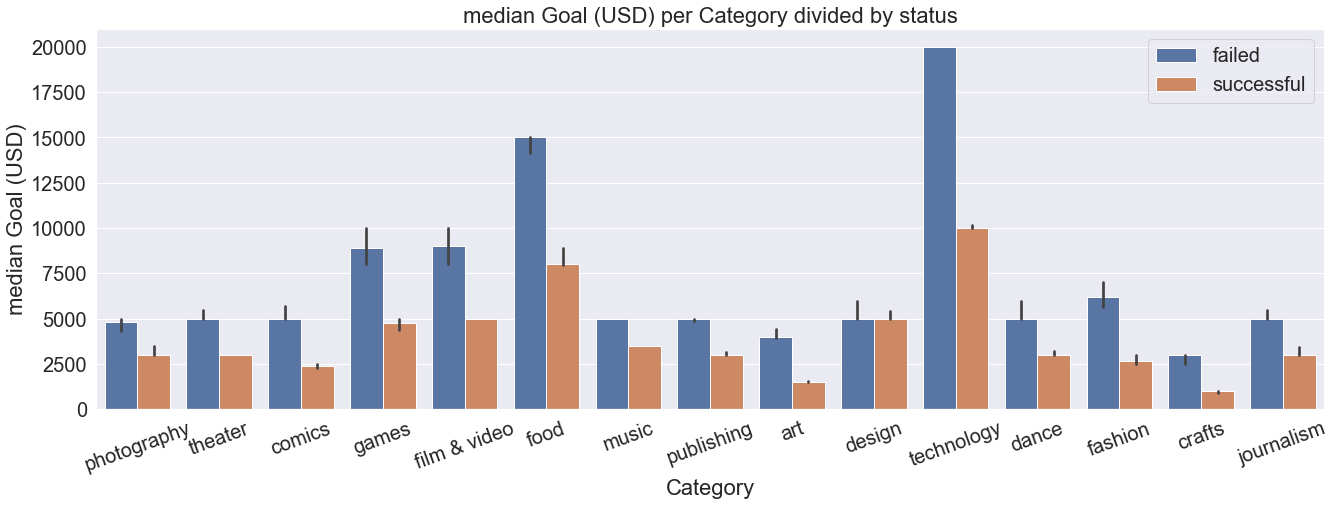

In [417]:
plt.figure(figsize=(22,7))
ax = sns.barplot(x="parent_category",y="USD_goal", estimator=median, hue= "state", data=train_data)
ax.set_xlabel("Category",fontsize=22);
ax.set_ylabel("median Goal (USD)",fontsize=22);
ax.set_title("median Goal (USD) per Category divided by status",fontsize=22)
plt.xticks(fontsize= 20, rotation=20)
plt.yticks(fontsize= 20)
plt.legend(fontsize= 20)
plt.savefig('figures/median Goal (USD) per Category divided by status.png')


## "backers count"

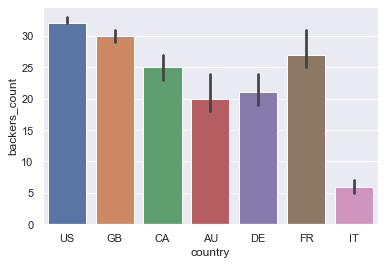

In [418]:
sns.barplot(x="country",y="backers_count", estimator= median,data=train_data, order=train_data["country"].value_counts().iloc[:7].index)
plt.savefig('figures/barplot_backerscount(median)_sorted_by_the top_7_countries.png')

## staff-pick

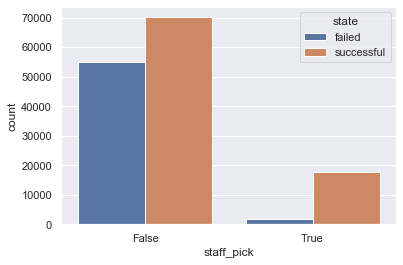

In [419]:
sns.countplot(hue="state", data=train_data, x="staff_pick")
plt.savefig('figures/barplot_staff-pick_state.png')

## Duration

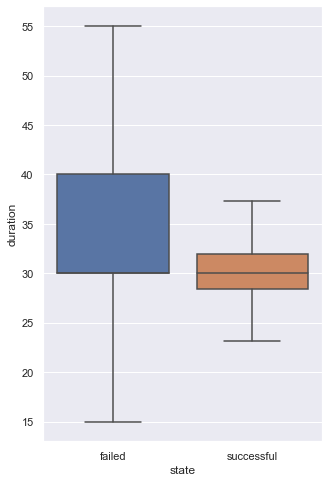

In [420]:
plt.figure(figsize=(5,8))
ax=sns.boxplot(y= "duration", x="state", data= train_data, showfliers=False)

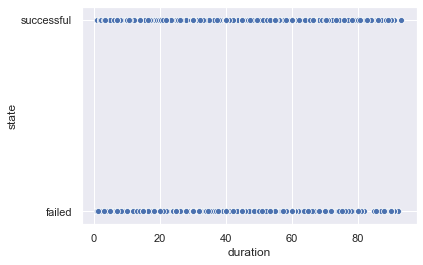

In [421]:
sns.scatterplot(x="duration", y="state",
                #hue="clarity", size="depth",
                #palette="ch:r=-.2,d=.3_r",
                #hue_order=clarity_ranking,
                #sizes=(1, 8), linewidth=0,
                data=train_data)

## blurb length

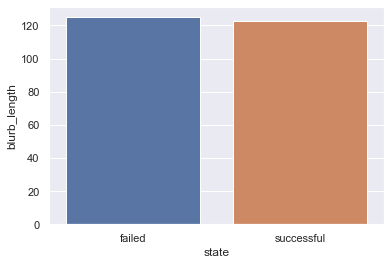

In [422]:
ax = sns.barplot(x= "state", y ="blurb_length", estimator= median, data=train_data)

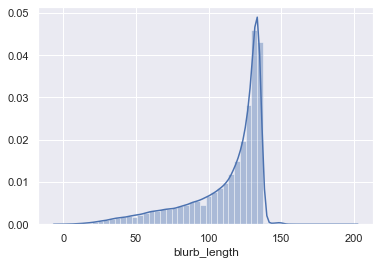

In [423]:
sns.distplot(train_data["blurb_length"],color="b",hist=True)


## name length 

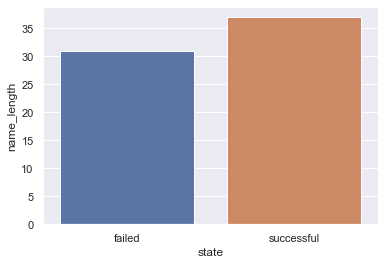

In [424]:
ax = sns.barplot(x= "state", y ="name_length", estimator= median, data=train_data)

In [425]:
df_test = train_data[train_data["name_length"]<30]

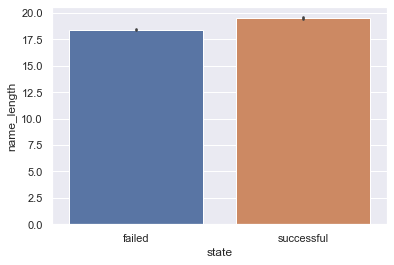

In [426]:
ax = sns.barplot(x= "state", y ="name_length", data=df_test)

## correlation matrix

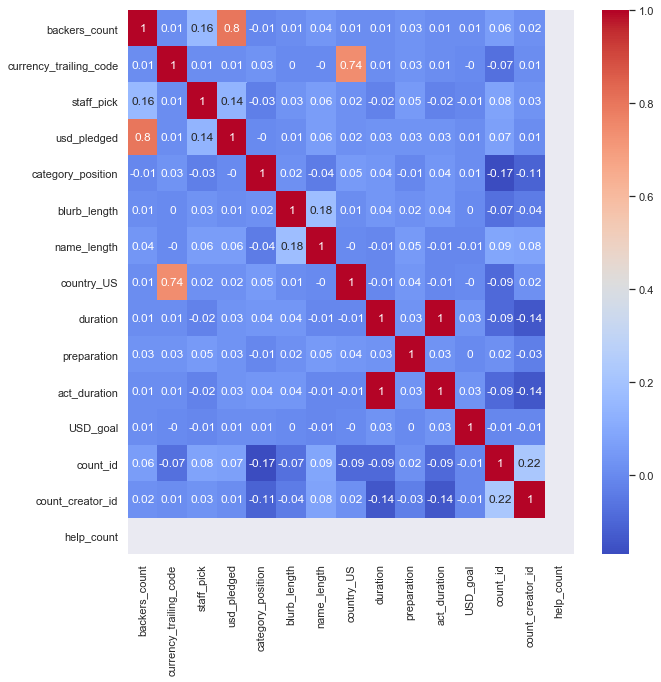

In [427]:
plt.figure(figsize=(10,10))
ax=sns.heatmap(train_data.corr().round(2),cmap="coolwarm",annot=True)
plt.savefig('figures/correlations_matrix.png')

# Predictive Modeling

In [428]:
df2.columns

Index(['backers_count', 'country', 'currency', 'currency_trailing_code',
       'staff_pick', 'state', 'usd_pledged', 'usd_type', 'category_name',
       'category_position', 'location_country', 'location_type',
       'blurb_length', 'name_length', 'country_US', 'duration', 'preparation',
       'act_duration', 'USD_goal', 'count_id', 'count_creator_id',
       'parent_category'],
      dtype='object')

In [429]:
num_features = list(df2.columns[df2.dtypes!=object])
num_features.remove("backers_count")
num_features.remove("usd_pledged")
num_features.remove("category_position")
num_features.remove("preparation")
num_features.remove("currency_trailing_code")
num_features.remove("count_id")
num_features.remove("act_duration")
num_features

['staff_pick',
 'blurb_length',
 'name_length',
 'country_US',
 'duration',
 'USD_goal',
 'count_creator_id']

In [430]:
cat_features = list(df2.columns[df2.dtypes==object])
cat_features.remove("state")
cat_features.remove("category_name")
cat_features

['country',
 'currency',
 'usd_type',
 'location_country',
 'location_type',
 'parent_category']

## built the Pipeline

In [431]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))])

In [432]:
# Complete pipeline
preprocessor = ColumnTransformer([
                                ('num', num_pipeline, num_features),
                                ('cat', cat_pipeline, cat_features)])

## Logistic Regression

In [433]:
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [434]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted_log = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

In [435]:
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_log)))
print(classification_report(y_train, y_train_predicted_log))

Accuracy: 0.75
              precision    recall  f1-score   support

      failed       0.72      0.60      0.65     56545
  successful       0.77      0.85      0.81     87953

    accuracy                           0.75    144498
   macro avg       0.74      0.73      0.73    144498
weighted avg       0.75      0.75      0.75    144498



### GridSearch

In [436]:
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.01, 0.1, 1, 10, 100]
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [437]:
grid_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   37.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   37.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [438]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.75
Best parameters:
{'logreg__C': 10, 'logreg__penalty': 'l2'}


best score and best parameter bevore we remove "currency_trailing_code", "count_id", "preparation", "act_duration", "category_name"
Best score:
0.86
Best parameters:
{'logreg__C': 10, 'logreg__penalty': 'l2'}

In [439]:
# Save best model as best_model
best_model = grid_logreg.best_estimator_['logreg']

## Random Forest

In [440]:
pipe_R_forest= Pipeline([('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(n_estimators=70))])

In [441]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted_R_forest = cross_val_predict(pipe_R_forest, X_train, y_train, cv=5)

In [442]:
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_R_forest)))
print(classification_report(y_train, y_train_predicted_R_forest))

Accuracy: 0.79
              precision    recall  f1-score   support

      failed       0.75      0.70      0.72     56545
  successful       0.82      0.85      0.83     87953

    accuracy                           0.79    144498
   macro avg       0.78      0.77      0.78    144498
weighted avg       0.79      0.79      0.79    144498



### GridSearch

In [443]:
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_25 = int(round(len(X_train)/4))

param_R_forest = {'classifier__bootstrap': [True, False],
                'classifier__max_depth': [ 2, 3, 4],
                'classifier__n_estimators': [samples_1, samples_10, samples_25]}



grid_R_forest = GridSearchCV(pipe_R_forest, param_grid=param_R_forest, cv=3, scoring='accuracy', 
                             verbose=5, n_jobs=-1)

In [444]:
grid_R_forest.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 119.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [445]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_R_forest.best_score_))
print("Best parameters:\n{}".format(grid_R_forest.best_params_))

Best score:
0.66
Best parameters:
{'classifier__bootstrap': True, 'classifier__max_depth': 4, 'classifier__n_estimators': 1445}


best score and best parameter bevore we remove "currency_trailing_code", "count_id", "preparation", "act_duration", "category_name"
Best score:
0.69
Best parameters:
{'classifier__bootstrap': False, 'classifier__max_depth': 4, 'classifier__n_estimators': 1445}

In [446]:
best_model2 = grid_R_forest.best_estimator_["classifier"]

## AdaBoostClassifier

In [447]:
pipe_AdaBoost= Pipeline([('preprocessor', preprocessor),
                         ('AdaBoost', AdaBoostClassifier(random_state=Rseed, base_estimator=DecisionTreeClassifier()))])

In [448]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted_AdaBoost = cross_val_predict(pipe_AdaBoost, X_train, y_train, cv=5)

In [449]:
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_AdaBoost)))
print(classification_report(y_train, y_train_predicted_AdaBoost))

Accuracy: 0.76
              precision    recall  f1-score   support

      failed       0.70      0.67      0.68     56545
  successful       0.79      0.82      0.81     87953

    accuracy                           0.76    144498
   macro avg       0.75      0.74      0.75    144498
weighted avg       0.76      0.76      0.76    144498



### GridSearch

In [450]:
param_AdaBoost = {'AdaBoost__n_estimators':[50, 120],                
                  'AdaBoost__learning_rate':[0.25, 0.5, 0.75],               
                  'AdaBoost__base_estimator__min_samples_split' : np.arange(2, 4, 2),               
                  'AdaBoost__base_estimator__max_depth' : np.arange(2, 4, 1)}



grid_AdaBoost = GridSearchCV(pipe_AdaBoost, param_grid=param_AdaBoost, cv=3, scoring='accuracy', 
                            verbose=5, n_jobs=-1).fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.2min finished


In [451]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_AdaBoost.best_score_))
print("Best parameters:\n{}".format(grid_AdaBoost.best_params_))

Best score:
0.80
Best parameters:
{'AdaBoost__base_estimator__max_depth': 3, 'AdaBoost__base_estimator__min_samples_split': 2, 'AdaBoost__learning_rate': 0.75, 'AdaBoost__n_estimators': 120}


best score and best parameter bevore we remove "currency_trailing_code", "count_id", "preparation", "act_duration", "category_name"

Best score:
0.87
Best parameters:
{'AdaBoost__base_estimator__max_depth': 3, 'AdaBoost__base_estimator__min_samples_split': 2, 'AdaBoost__learning_rate': 0.25, 'AdaBoost__n_estimators': 120}

In [452]:
# Save best model as best_model
best_model3 = grid_AdaBoost.best_estimator_['AdaBoost']

## Support Vector Machine 

In [453]:
pipe_SVM= Pipeline([('preprocessor', preprocessor),
                         ('SVC', SVC(kernel='linear', C=1))])

In [454]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
y_train_predicted_SVM = cross_val_predict(pipe_SVM, X_train, y_train, cv=5)

In [455]:
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_SVM)))
print(classification_report(y_train, y_train_predicted_SVM))

Accuracy: 0.75
              precision    recall  f1-score   support

      failed       0.72      0.58      0.64     56545
  successful       0.76      0.86      0.80     87953

    accuracy                           0.75    144498
   macro avg       0.74      0.72      0.72    144498
weighted avg       0.74      0.75      0.74    144498



### Grid Search

In [456]:
param_SVM = {'SVC__C': [5, 10, 15],
           'SVC__gamma': [0.0001, 0.0005, 0.001]}

In [457]:
grid_SVM = GridSearchCV(pipe_SVM, param_grid=param_SVM, cv=3, scoring='accuracy', 
                            verbose=5, n_jobs=-1).fit(X_train, y_train)

In [458]:
# Show best parameters

print('Best score:\n{:.2f}'.format(grid_SVM.best_score_))
print("Best parameters:\n{}".format(grid_SVM.best_params_))

In [473]:
# Save best model as best_model4
best_model4 = grid_SVM.best_estimator_['SVM']

NameError: name 'grid_SVM' is not defined

## Final Evaluation

In [460]:
# Preparing the test set 
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [461]:
X_test_preprocessed

<48166x263 sparse matrix of type '<class 'numpy.float64'>'
	with 626150 stored elements in Compressed Sparse Row format>

In [462]:
X_test.columns

Index(['backers_count', 'country', 'currency', 'currency_trailing_code',
       'staff_pick', 'usd_pledged', 'usd_type', 'category_name',
       'category_position', 'location_country', 'location_type',
       'blurb_length', 'name_length', 'country_US', 'duration', 'preparation',
       'act_duration', 'USD_goal', 'count_id', 'count_creator_id',
       'parent_category'],
      dtype='object')

In [474]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted_logreg = best_model.predict(X_test_preprocessed)
y_test_predicted_R_forest = best_model2.predict(X_test_preprocessed)
y_test_predicted_AdaBoost = best_model3.predict(X_test_preprocessed)
#y_test_predict_SVM = best_model4.predict(X_test_preprocessed)

print("Logistic Regression\n----------")
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_logreg)))
print(classification_report(y_test, y_test_predicted_logreg))

print("\nRandom Forest\n----------")
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_R_forest)))
print(classification_report(y_test, y_test_predicted_R_forest))

print("\nAdaBoost Classifier\n----------")
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_AdaBoost)))
print(classification_report(y_test, y_test_predicted_AdaBoost))

print("\nSupport Vector Mschine\n----------")
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_SVM)))
print(classification_report(y_test, y_test_predicted_SVM))

Logistic Regression
----------
Accuracy: 0.76
              precision    recall  f1-score   support

      failed       0.72      0.60      0.66     18654
  successful       0.77      0.85      0.81     29512

    accuracy                           0.76     48166
   macro avg       0.75      0.73      0.74     48166
weighted avg       0.75      0.76      0.75     48166


Random Forest
----------
Accuracy: 0.66
              precision    recall  f1-score   support

      failed       0.94      0.14      0.25     18654
  successful       0.65      0.99      0.78     29512

    accuracy                           0.66     48166
   macro avg       0.79      0.57      0.52     48166
weighted avg       0.76      0.66      0.58     48166


AdaBoost Classifier
----------
Accuracy: 0.80
              precision    recall  f1-score   support

      failed       0.77      0.70      0.73     18654
  successful       0.82      0.87      0.84     29512

    accuracy                           0.80     

NameError: name 'y_test_predicted_SVM' is not defined

# Data Visualization

In [464]:
onehot_columns = list(pipe_AdaBoost.named_steps["preprocessor"].named_transformers_['cat'].named_steps['1hot'].get_feature_names(input_features=cat_features))
numeric_features_listasd = list(num_features)
numeric_features_listasd.extend(onehot_columns)

In [465]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = list(np.argsort(importances)[::-1])
    #print(indices[:10])
    #columns = X_train.columns.values[indices[:9]]
    columns = []
    for col in indices[:10]:
        columns.append(numeric_features_listasd[col])
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (13,6))
    plt.title("Normalized Weights for First Nine Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(9), columns)
    plt.xlim((-0.5, 8.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    plt.xticks(rotation=45)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show() 

## Feature Importance 

### Logistic Regression

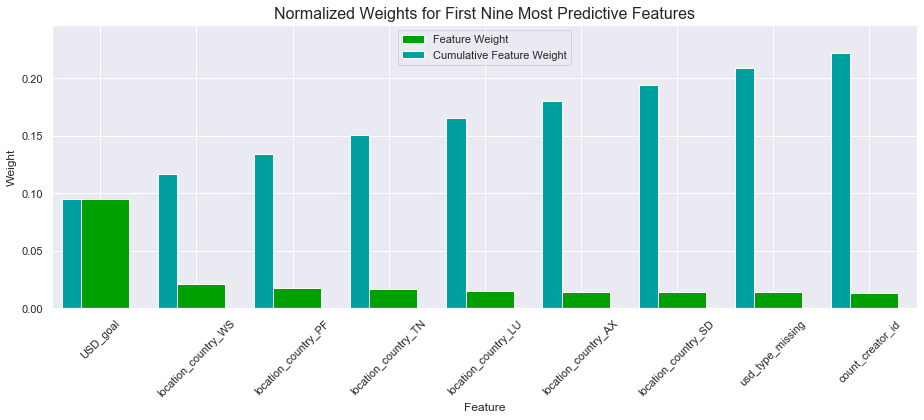

In [466]:
imp = abs(best_model.coef_[0])
feature_importance = (imp / imp.sum())

importances = feature_importance
# Plot
feature_plot(importances, numeric_features_listasd, y_train)

### Random Forest

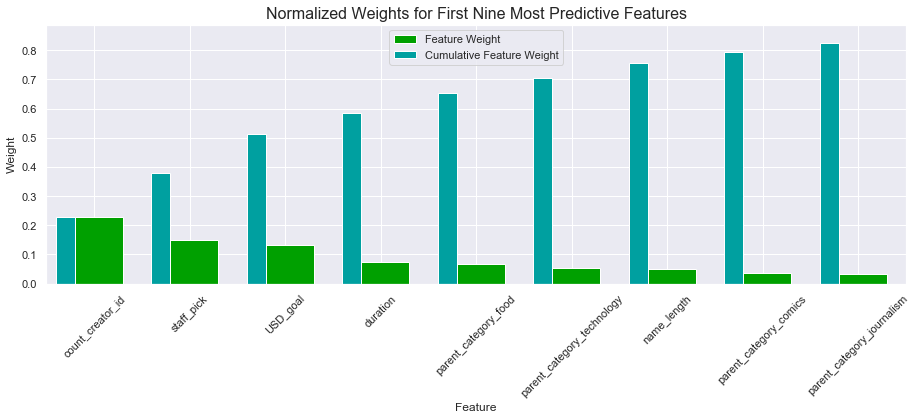

In [467]:
importances = best_model2.feature_importances_
# Plot
feature_plot(importances, X_test_preprocessed, y_train)

### AdaBoost Classifier

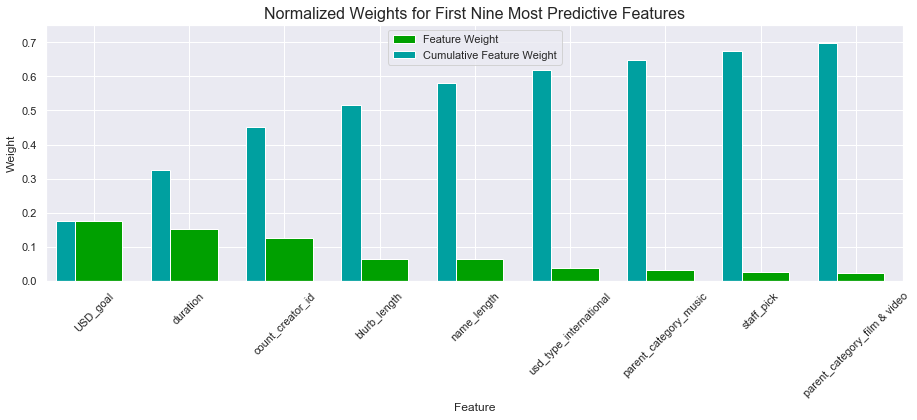

In [468]:
importances = best_model3.feature_importances_
# Plot
feature_plot(importances, X_test_preprocessed, y_train)

## Confusion Matrix for our best Model 

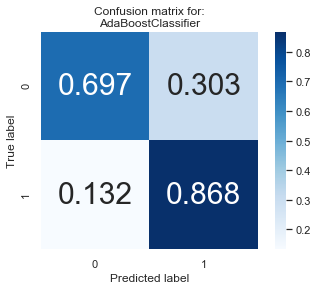

In [469]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

for i,model in enumerate([best_model3]):
    cm = confusion_matrix(y_test, y_test_predicted_AdaBoost)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

# Future Work 